# Imports

In [2]:
import numpy as np
import sympy as sp
from sympy import *
import re

import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.colors as c
from matplotlib.ticker import PercentFormatter
from matplotlib import rcParams

from math import log10, floor
from math import *
import math

from IPython.display import display, Latex
from IPython.display import Markdown as md

import scipy.constants as pc
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy import stats

# Matplotlib Style changes

In [3]:
rcParams['font.size'] = 15
rcParams['font.weight'] = 'bold'
rcParams['text.usetex'] = True
rcParams['axes.grid'] = True
rcParams['font.family'] = 'serif'
rcParams['font.sans-serif'] = ['Latin Modern Math']
rcParams['xtick.labelsize'] = 18
rcParams['ytick.labelsize'] = 18
rcParams["xtick.minor.size"] =  4
rcParams["ytick.minor.size"] =  4
rcParams["xtick.minor.visible"] =  True
rcParams["ytick.minor.visible"] =  True

# Statistical Selfcoded functions

In [4]:




# easier formula for gaussian error propagation with addition
def einfachGaussAdd(unsicherheiten, koeffizienten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (koeffizienten[i]*unsicherheiten[i])**2
    return sqrt(dz)

# easier formula for gaussian error propagation with multiplication
def einfachGaussMult(unsicherheiten, werte, exponenten):
    dz = 0
    for i in range (unsicherheiten.size):
        dz += (exponenten[i]*unsicherheiten[i]/werte[i])**2
    return sqrt(dz)

# Formlae for Gaußen Error propagation with result
def DivisionMitFehler(A, deltaA, B, deltaB): # Für C=A/B
    C = A/B
    deltaC = abs(C) * math.sqrt((deltaA / A)**2 + (deltaB / B)**2)
    return C,deltaC

def MultiplikationMitFehler(A, deltaA, B, deltaB): #Für C=A*B
    C = A * B
    deltaC = abs(C) * ((deltaA / abs(A)) + (deltaB / abs(B)))
    return C, deltaC

# t-value for without literature value
def vertraeglichkeit(am_1, am_2, stu_1, stu_2):
    return (np.abs(am_1-am_2)/(sqrt((stu_1**2)*(stu_2**2))))

# analytic linear regression y(x)=m*x + b calculates m
def bestM(x, y):
    return (x.size*sum(x*y)-sum(x)*sum(y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression y(x)=m*x + b calculates b
def bestB(x, y):
    return (sum(x**2)*sum(y)-sum(x)*sum(x*y))/(x.size*sum(x**2)-sum(x)**2)

# analytic linear regression calculates variance 
# (only used for next two functions, never gets called on its own, enhances readability) 
def streuung(x, y):
    s = 0
    for i in range(x.size):
        s += (y[i]-(bestB(x, y)+bestM(x, y)*x[i]))**2
    return np.sqrt(s/(x.size-2))

# analytic linear regression y(x)=m*x + b calculates error on m
def stuM(x, y):
    s = streuung(x, y)
    return s*np.sqrt(x.size/((x.size*sum(x**2)-sum(x)**2)))

# analytic linear regression y(x)=m*x + b calculates error on b
def stuB(x, y):
    s = streuung(x, y)
    return s*np.sqrt(sum(x**2)/((x.size*sum(x**2)-sum(x)**2)))


# Ergebnisse des Versuchs Supraleiter

Wichtige Anmerkungen zu den Codekonventionen:
- Variablennamen nutzen CamelCase und kürzen ab z.B.: linsenAbstandGegenstand was dem Abstand der Linse von der Gegenstandseite entspricht
- Fehler werden hierbei mit dem Suffix Err im CamelCase gekennzeichnet z.B.: abstandErr entspricht dem Fehler der Abstandsvariable 
- Einheiten stehen kommentiert nach den Einheiten z.B.: x = 3 # mm oder "vMax = 2 # V"

### Versuchsablauf 
Für den ersten Versuchsteil wurde ein sekbstgelöteter Messkopf verwendet, dieser Bestand aus einem Kupferdraht, einer Platine und einem Widerstandsthermometer. Es befanden sich außerdem Kabel an sechs stellen um die Spannung des Drahtes mit einer Vier-Punkt-Messung und die Spannung des Widerstands mit einer Zwei-Punkt-Messung zu messen. Der Messkopf wurde in den Flüssigen Stickstoff gelegt bis ein Temperaturplateau erreicht wurde und anschließend wurde der aufwärmprozess aufgenommen. Diese Messung diente auch der Kalibrierung / Eichung.

Für den zweiten  Versuchsteil wurde der vorgefertigte Messkopf mit dem Supraleiter verwendet. Es wurden hier der Aufwärm- sowie der Abkühlvorgang aufgezeichnet.

Die Daten wurden in beiden Versuchsteilen mit der Software CassyLab aufgenommen und als .csv gesichert, diese Dateien werden im Folgenden eingelesen.


## 1. Versuchsteil: Messung mit dem Kupferdraht

### Einlesung der Daten

In [5]:
# Einlesen der Daten
messung1HTS = pd.read_csv('Messung_1_HTS.csv')

zeitMessung1HTS = messung1HTS['Zeit t / s'].to_numpy()
spannungUA1Messung1HTS = messung1HTS['Spannung U_A1 / V'].to_numpy()
spannungUB1Messung1HTS = messung1HTS['Spannung U_B1 / V'].to_numpy()


messung2HTS = pd.read_csv('Messung_2_HTS.csv')

zeitMessung2HTS = messung2HTS['Zeit t / s'].to_numpy()
spannungUA1Messung2HTS = messung2HTS['Spannung U_A1 / V'].to_numpy()
spannungUB1Messung2HTS = messung2HTS['Spannung U_B1 / V'].to_numpy()


messung3HTS = pd.read_csv('Messung_1_HTS.csv')

zeitMessung3HTS = messung3HTS['Zeit t / s'].to_numpy()
spannungUA1Messung3HTS = messung3HTS['Spannung U_A1 / V'].to_numpy()
spannungUB1Messung3HTS = messung3HTS['Spannung U_B1 / V'].to_numpy()


kupferMessung1 = pd.read_csv('Messung_1_Kupfer.csv')

zeitKupferMessung1 = kupferMessung1['Zeit t / s'].to_numpy()
spannungUA1KupferMessung1 = kupferMessung1['Spannung U_A1 / V'].to_numpy()
spannungUB1KupferMessung1 = kupferMessung1['Spannung U_B1 / V'].to_numpy()


kupferMessung2 = pd.read_csv('Messung_2_Kupfer.csv')

zeitKupferMessung2 = kupferMessung2['Zeit t / s'].to_numpy()
spannungUA1KupferMessung2 = kupferMessung2['Spannung U_A1 / V'].to_numpy()
spannungUB1KupferMessung2 = kupferMessung2['Spannung U_B1 / V'].to_numpy()


kupferMessung3 = pd.read_csv('Messung_3_Kupfer.csv')

zeitKupferMessung3 = kupferMessung3['Zeit t / s'].to_numpy()
spannungUA1KupferMessung3 = kupferMessung3['Spannung U_A1 / V'].to_numpy()
spannungUB1KupferMessung3 = kupferMessung3['Spannung U_B1 / V'].to_numpy()


kupferMessung4 = pd.read_csv('Messung_4_Kupfer.csv')

zeitKupferMessung4 = kupferMessung4['Zeit t / s'].to_numpy()
spannungUA1KupferMessung4 = kupferMessung4['Spannung U_A1 / V'].to_numpy()
spannungUB1KupferMessung4 = kupferMessung4['Spannung U_B1 / V'].to_numpy()


kupferMessung5 = pd.read_csv('Messung_5_Kupfer.csv')

zeitKupferMessung5 = kupferMessung5['Zeit t / s'].to_numpy()
spannungUA1KupferMessung5 = kupferMessung5['Spannung U_A1 / V'].to_numpy()
spannungUB1KupferMessung5 = kupferMessung5['Spannung U_B1 / V'].to_numpy()

### Aufzeichnen der Daten

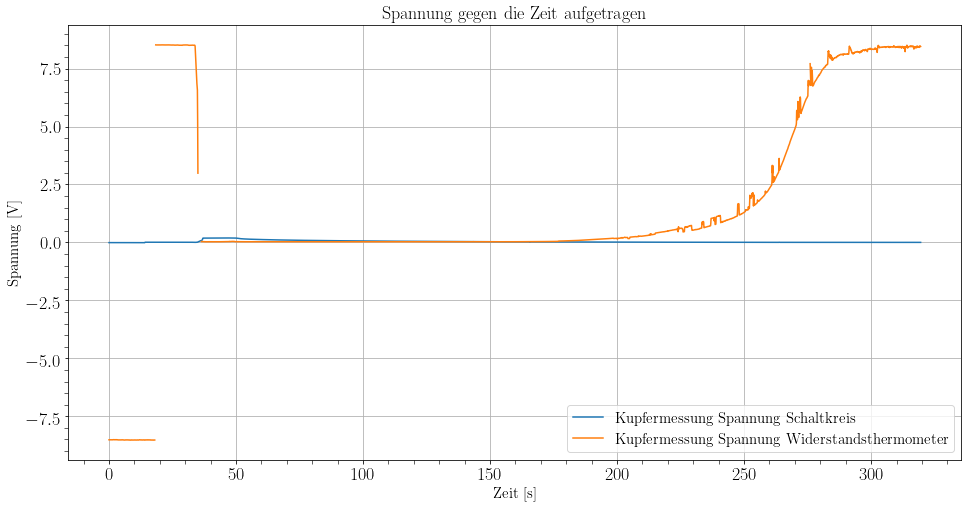

In [10]:
# Define the sigmoid function
def sigmoidFunc(x, a, b, c, d):
    return a/(1 + np.exp(-b*x + c)) + d


# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
# plt.plot(zeitKupferMessung1, spannungUA1KupferMessung1, label="1")
# plt.plot(zeitKupferMessung2, spannungUA1KupferMessung2, label="2")
# plt.plot(zeitKupferMessung3, spannungUA1KupferMessung3, label="3")
# plt.plot(zeitKupferMessung4, spannungUA1KupferMessung4, label="4")
plt.plot(zeitKupferMessung5, spannungUA1KupferMessung5, label="Kupfermessung Spannung Schaltkreis")
plt.plot(zeitKupferMessung5, spannungUB1KupferMessung5, label="Kupfermessung Spannung Widerstandsthermometer")



# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()


### Fits berechnen

platueMean 0.19223382085843466 platueMeanErr 2.0616035797558438e-06


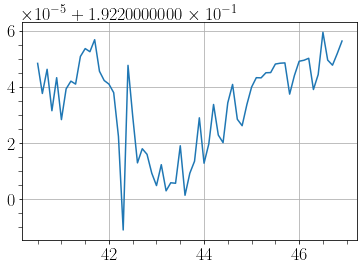

In [185]:
#Spannung des Plateaus berechnen - entspricht Temperatur von flüssigem Stickstoff

def timeToIndices(timeStart, timeEnd, timeArray):
    # Index finden, welcher dem gewünschten Zeitwert Entspricht
    startIndex = np.argmax(timeArray >= timeStart)
    endIndex = np.argmax(timeArray >= timeEnd)
    
    return startIndex, endIndex


def clearNaNs(xArray,yArray):
    nanMask = np.isnan(yArray)
    nanIndices = np.where(nanMask)
    
    xArrayClean = np.delete(xArray, nanIndices[0])
    yArrayClean = np.delete(yArray, nanIndices[0])
    
    return xArrayClean, yArrayClean
    

startTimePlateu = 40.5
endTimePlateu = 47

startIndexPlateu, endIndexPlateu = timeToIndices(startTimePlateu, endTimePlateu, zeitKupferMessung5)

#Slicen der Arrays für den Fit
xDataPlateuUnclean = zeitKupferMessung5[startIndexPlateu:endIndexPlateu]
yDataPlateuUnclean = spannungUA1KupferMessung5[startIndexPlateu:endIndexPlateu]
    
#Entfernen von NaN Werten
xDataPlateu = clearNaNs(xDataPlateuUnclean,yDataPlateuUnclean)[0]
yDataPlateu = clearNaNs(xDataPlateuUnclean,yDataPlateuUnclean)[1]

# Bestimmung Mittelwert Plateu
platueMean = np.mean(yDataPlateu)
platueMeanErr = np.std(yDataPlateu, ddof=1) / np.sqrt(len(yDataPlateu))

#Ausgabe Spannung PLateu Mittelwer
print("platueMean",platueMean,"platueMeanErr",platueMeanErr)

# PLateu Plotten 
plt.plot(xDataPlateu,yDataPlateu)



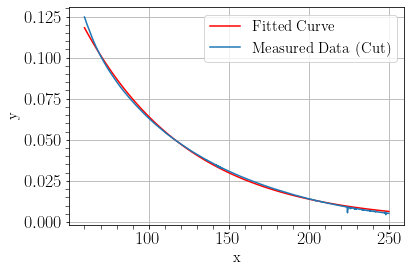

Fitted Parameters:
a = 2.290166403043087e-05
b = -0.01518491076512735
c = 9.461712101364792
d = -0.00024073935194828235


In [186]:
# Berechnen von Fits 

# Define the exponential function
def exponentialFunc(x, a, b, c, d):
    return a * np.exp(b * x + c) + d


def fitExponential(xData,yData,startTime,endTime,initialGuesses):
    
    startIndex = timeToIndices(startTime, endTime, xData)[0]
    endIndex = timeToIndices(startTime, endTime, xData)[1]
    
    # Slicen der Arrays für den Fit
    xDataFitUnclean = xData[startIndex:endIndex]
    yDataFitUnclean = yData[startIndex:endIndex]
    
    # Entfernen von NaN Werten
    xDataFit = clearNaNs(xDataFitUnclean,yDataFitUnclean)[0]
    yDataFit = clearNaNs(xDataFitUnclean,yDataFitUnclean)[1]
    
    # Curve Fit mittels scypy
    params, covariance = curve_fit(exponentialFunc, xDataFit, yDataFit,
                                   p0=initialGuesses,maxfev = 80000)
    
    # Parameter Extrahieren
    aFit, bFit, cFit, dFit = params
    
    
    xFit = np.linspace(min(xDataFit), max(xDataFit), 100)
    yFit = exponentialFunc(xFit, aFit, bFit, cFit, dFit)
    
    fitReturn = aFit, bFit, cFit, dFit, covariance, xFit, yFit, xDataFit, yDataFit
    
    return fitReturn


initialGuesses5 = np.array([0.00001,-0.01,10,0])
fitKupfer5 = fitExponential(zeitKupferMessung5, spannungUA1KupferMessung5,60,250,initialGuesses5)




# Initial Guess Plot
# plt.plot(np.linspace(60,250,100),exponentialFunc(np.linspace(60,250,100),
#                   initialGuesses5[0], initialGuesses5[1], initialGuesses5[2], initialGuesses5[3]))

# Originale und Fittet Curve Plotten
plt.errorbar(fitKupfer5[7], fitKupfer5[8], label="Measured Data (Cut)")
plt.plot(fitKupfer5[5], fitKupfer5[6], 'r-', label="Fitted Curve")

# Plot Labeln
plt.xlabel("x")
plt.ylabel("y")
plt.legend()
plt.grid(True)
plt.show()

# Print the fitted parameters
print("Fitted Parameters:")
print(f"a = {fitKupfer5[0]}")
print(f"b = {fitKupfer5[1]}")
print(f"c = {fitKupfer5[2]}")
print(f"d = {fitKupfer5[3]}")

md(f"""Es ergibt sich eine kritische Temperatur von: $ \pm $ [°C]\n  
   """)

In [ ]:
# Umwandlung Spannung -> Temperatur

spannungKalt = 1
spannungWarm = 1

tempFlüssigerStickstocff = 1
tempRaum = 20

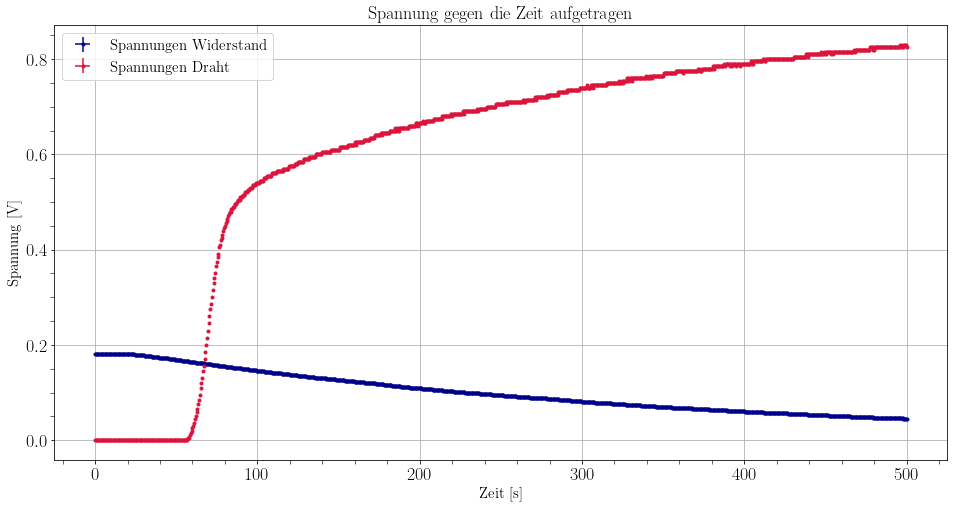

0.166


In [16]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))

# Gemessene Spannungswerte auftragen
plt.errorbar(zeitMessung1HTS, spannungUA1Messung1HTS, xerr=0, yerr=0, 
             fmt='.', color='darkblue', label='Spannungen Widerstand')

plt.errorbar(zeitMessung1HTS, spannungUB1Messung1HTS, xerr=0, yerr=0, 
             fmt='.', color='crimson', label='Spannungen Draht')

# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()

print(spannungUA1Messung1HTS[max(np.where(spannungUB1Messung1HTS==0)[0])])

## 2. Versuchsteil: Messung des Supraleiters

### Anzeigen der Daten

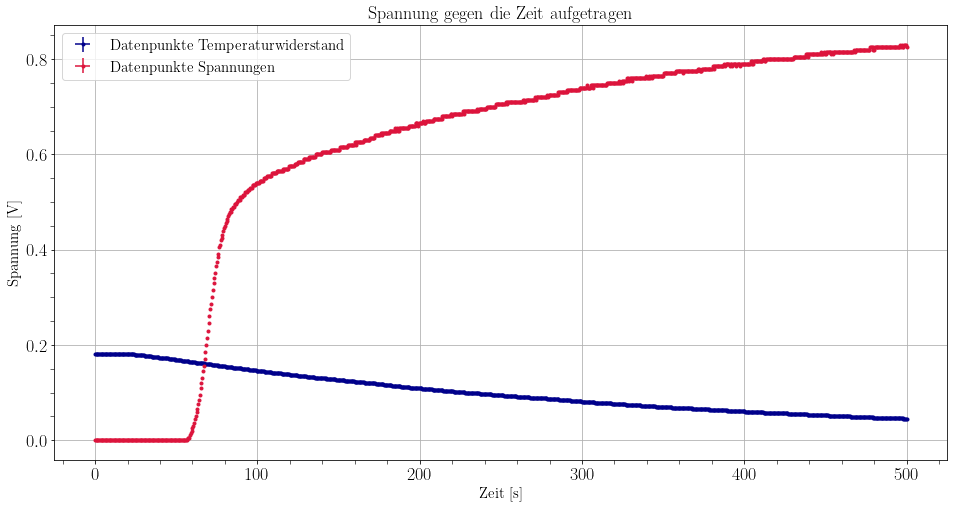

Minimalpunkt liegt bei: $ \pm $ [Hz]
  
   Dies entspricht einer Lichtgeschwindigkeit von: $ \pm $ [km/s]

In [9]:
# Plotgröße anpassen
plt.figure(figsize=(16, 8))  

# Gemessene Spannungswerte auftragen
plt.errorbar(zeitMessung1HTS, spannungUA1Messung1HTS, xerr=0, yerr=0, 
             fmt='.', color='darkblue', label='Datenpunkte Temperaturwiderstand', marker=None)

plt.errorbar(zeitMessung1HTS, spannungUB1Messung1HTS, xerr=0, yerr=0, 
             fmt='.', color='crimson', label='Datenpunkte Spannungen', marker=None)

# labels und legend
plt.xlabel(r'Zeit [s]')
plt.ylabel(r'Spannung [V]')
plt.legend()

# Plot anzeigen lassen
plt.grid(True)
plt.title('Spannung gegen die Zeit aufgetragen')
plt.show()

# Ausgabe des Hz-Werts für den Minimalpunkt
md(f"""Minimalpunkt liegt bei: $ \pm $ [Hz]\n  
   Dies entspricht einer Lichtgeschwindigkeit von: $ \pm $ [km/s]""")

### Fit berechnen

### Berechnung t-Werte

In [ ]:
t

# Diskussion
## Zusammenfassung der Ergebnisse
Als kritische Temperatur des Kupferdrahtes $T_\text{c, cu}$ und der dazugehörige t-Wert $t_\text{cu}$ unter Vergleich mit dem Literaturwert ergaben sich:
$$
	T_\text{c, cu} = 0.0 \pm 0.0 \deg \text{K} \quad  t_\text{cu} = 0
$$
Damit können unsere Messungen die Literaturwerte der kritischen Temperatur des Kupferdrahtes (nicht) bestätigen. Dabei betrag der Residualwiderstand $R_\text{res}$:
$$
	R_\text{res} = 0.0 \pm 0.0 \Omega
$$
Dies stimmt auch (nicht) mit der Literatur überein.
Für die kritische Temperatur des Supraleiters und den dazugehörige t-Wert unter Vergleich mit dem Literaturwert $t_\text{su}$ wurden folgende Werte ermittelt:
$$
	T_\text{c, su} = 0.0 \pm 0.0 \degree \text{K} \quad  t_\text{su} = 0
$$.\\
Damit können unsere Messungen die Literaturwerte der kritischen Temperatur des Kupferdrahtes (nicht) bestätigen.

# Verbesserte Messmethoden